In [1]:
!python3 -m pip install -e .

import random
import time
from collections import deque

import numpy as np

import torch as tc
import torch.optim as opt

import gym
import gym_snake
env = gym.make('snake-v0')

from model import NN
from core import DEVICE,render_inline

Obtaining file:///home/lobo/gym-snake
  Attempting uninstall: gym-snake
    Found existing installation: gym-snake 0.0.1
    Uninstalling gym-snake-0.0.1:
      Successfully uninstalled gym-snake-0.0.1
  Running setup.py develop for gym-snake


In [30]:
#load
net=NN().cuda()
net.load_state_dict(tc.load('./netw.pt'))
net.eval();

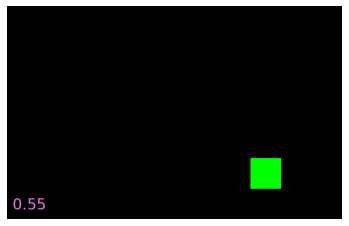

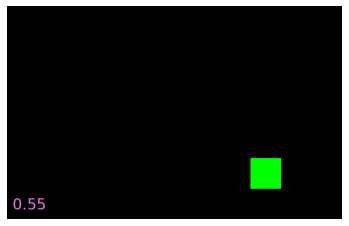

In [34]:

#net=NN().cuda()
with tc.no_grad():
    obs=env.reset()
    while True:
        res=net(tc.tensor(obs[0]).to(DEVICE),tc.tensor(0)).detach().squeeze().tolist()
        obs, rwd, done, _ = env.step(res.index(max(res)))
        #env.render()
        render_inline(env)
        if done:
            break
env.close()

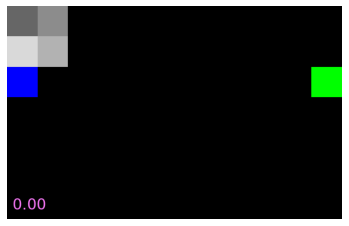

ValueError: invalid literal for int() with base 10: ''

In [4]:
##### Human Input
obs=env.reset()
render_inline(env)
done=False
while not done:
    obs, rwd, done, _ = env.step(int(input()))
    render_inline(env)
env.close()